In [331]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [332]:
train_df = pd.read_csv('train.csv', parse_dates=['Dates'])
#test_df = pd.read_csv('test.csv')
print(train_df.shape)
#print(test_df.shape)

(878049, 9)


In [333]:
# from datetime import date

# date_x = date(2006, 1, 1)
# train_df = train_df[pd.to_datetime(train_df['Dates'].dt.date) >= date_x]
# print(train_df.shape)


In [334]:

train_df = train_df.sample(frac=0.5, random_state=1)

In [335]:
all_classes = ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS']

In [336]:
print('Any missing values?')
print('In train: ', pd.isnull(train_df).values.any())
#print('In test:  ', pandas.isnull(test).values.any())

Any missing values?
('In train: ', False)


In [337]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import Holiday, HolidayCalendarFactory, FR, DateOffset

def transform_date(df):
    """
    Split Dates into Date, Year, Month, Day, DayofYear, Hour and Minute
    """
    df['Date'] = pd.to_datetime(df['Dates'].dt.date)
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['DayOfYear'] = df['Dates'].dt.dayofyear   # the ordinal day of the year
    df['Time'] = df['Dates'].dt.hour + df['Dates'].dt.minute/60
    df['Hour'] = df['Dates'].dt.hour
    df['Minutes'] = df['Dates'].dt.minute
    del df['Dates']
    
    return df

def dummy_day_of_week(df):
    listOfDays = df['DayOfWeek'].unique()
    
    for day in listOfDays:
        col_name = "is" + day
        
        df[col_name] = ((df['DayOfWeek'] == day) == True)
        
    return df

def compute_working_days(df):
    """
    Check if working day, include information about holidays:
    New Year, Memorial Day, Independence Day, Labor Day, Thanksgiving, Black Friday, Christmas
    """
    cal = calendar()

    # create new rule for Black Friday
    USBlackFriday = Holiday('BlackFriday', month=11, day=1,
                            offset=DateOffset(weekday=FR(4)))

    # create own holiday calendar based on the above rules
    ownCal = HolidayCalendarFactory('OwnCalendar', cal, USBlackFriday)
    cal = ownCal()
    holidays = cal.holidays(start='2003-01-01', end='2015-05-13')

    # set flag according to whether the day is a holiday, a weekend or not
    df['isWorkingday'] = ((df['DayOfWeek'].isin(['Saturday', 'Sunday'])==False) & 
                          (df['Date'].isin(holidays)==False))

    # transform from True/False into 1/0
    df['isWorkingday'] = df['isWorkingday'].astype(int)
    
    return df
    
def compute_night(df):
    df['Night'] = True
    
    df.loc[(df['Month'] ==  1) & (df['Time'] > 7.3) & (df['Time'] < 17.3), 'Night'] = False
    df.loc[(df['Month'] ==  2) & (df['Time'] > 7.0) & (df['Time'] < 17.8), 'Night'] = False
    df.loc[(df['Month'] ==  3) & (df['Time'] > 6.3) & (df['Time'] < 18.3), 'Night'] = False
    df.loc[(df['Month'] ==  4) & (df['Time'] > 5.5) & (df['Time'] < 18.8), 'Night'] = False
    df.loc[(df['Month'] ==  5) & (df['Time'] > 5.0) & (df['Time'] < 19.3), 'Night'] = False
    df.loc[(df['Month'] ==  6) & (df['Time'] > 4.8) & (df['Time'] < 19.5), 'Night'] = False
    df.loc[(df['Month'] ==  7) & (df['Time'] > 5.0) & (df['Time'] < 19.5), 'Night'] = False
    df.loc[(df['Month'] ==  8) & (df['Time'] > 5.5) & (df['Time'] < 19.0), 'Night'] = False
    df.loc[(df['Month'] ==  9) & (df['Time'] > 5.8) & (df['Time'] < 18.3), 'Night'] = False
    df.loc[(df['Month'] == 10) & (df['Time'] > 6.3) & (df['Time'] < 17.5), 'Night'] = False
    df.loc[(df['Month'] == 11) & (df['Time'] > 6.8) & (df['Time'] < 17.0), 'Night'] = False
    df.loc[(df['Month'] == 12) & (df['Time'] > 7.3) & (df['Time'] < 16.9), 'Night'] = False

    # transform from True/False into 1/0
    df['Night'] = df['Night'].astype(int)
    return df

def features_date(df):
    df = transform_date(df)
    df = compute_working_days(df)
    df = compute_night(df)
    df = dummy_day_of_week(df)
    
    return df

In [338]:
def categorize_crimes(df):
    otherCrimes = ['WARRANTS','OTHER OFFENSES','WEAPON LAWS','SECONDARY CODES']
    familyCrimes = ['MISSING PERSON','RUNAWAY', 'FAMILY OFFENSES','SUICIDE']
    violentCrimes = ['ASSAULT','SEX OFFENSES FORCIBLE','ARSON','KIDNAPPING']
    theftBurglary = ['LARCENY/THEFT','VEHICLE THEFT','ROBBERY','BURGLARY','STOLEN PROPERTY','RECOVERED VEHICLE']
    economicCrimes = ['FORGERY/COUNTERFEITING','FRAUD', 'BRIBERY', 'EMBEZZLEMENT', 'BAD CHECKS', 'EXTORTION']
    publicDisorder = ['VANDALISM','NON-CRIMINAL', 'SUSPICIOUS OCC','TRESPASS','PROSTITUTION', 'DISORDERLY CONDUCT',
                  'LOITERING', 'SEX OFFENSES NON FORCIBLE', 'PORNOGRAPHY/OBSCENE MAT','TREA', 'GAMBLING']  
    drugsAlcohol = ['DRUNKENNESS','DRUG/NARCOTIC', 'DRIVING UNDER THE INFLUENCE', 'LIQUOR LAWS']
    
    df['isOtherCrimes'] = df['Category'].isin(otherCrimes)
    df['isFamilyCrimes'] = df['Category'].isin(familyCrimes)
    df['isViolentCrimes'] = df['Category'].isin(violentCrimes)
    df['isTheftBurglary'] = df['Category'].isin(theftBurglary)
    df['isEconomicCrimes'] = df['Category'].isin(economicCrimes)

    return df

def check_intersection(df):
    # check whether address is an intersection or not
    # one column, i.e. 1 for intersection and 0 for block should suffice
    df['isStreetCorner'] = df['Address'].apply(lambda x: 1 if '/' in x else 0)
    return df

def dummy_districts(df):
    listOfDistricts = df['PdDistrict'].unique()
    
    for district in listOfDistricts:
        col_name = "is" + district
        
        df[col_name] = ((df['PdDistrict'] == district) == True)
        
    return df

def features_crime(df):
    #df = categorize_crimes(df)
    df = check_intersection(df)
    df = dummy_districts(df)
    
    return df

In [339]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def xy_clean(df):
    # medians of X and Y by police district
    listOfPrecincts = df['PdDistrict'].unique()
    precinctX = (df.groupby('PdDistrict'))['X'].median()
    precinctY = (df.groupby('PdDistrict'))['Y'].median()

    # impute wrong values with the medians
    for i in range(len(listOfPrecincts)) :
        df.loc[ (df['Y'] > 38) & (df['PdDistrict'] == listOfPrecincts[i]), 'X'] = \
            precinctX[listOfPrecincts[i]]
        df.loc[(df['Y'] > 38) & (df['PdDistrict'] == listOfPrecincts[i]), 'Y'] = \
            precinctY[listOfPrecincts[i]]
            
    return df
        

def xy_scale(df):
    xy_scaler = MinMaxScaler() 
    xy_scaler.fit(df[["X","Y"]]) 
    df[["X","Y"]]=xy_scaler.transform(df[["X","Y"]]) 
    
    return df

def xy_rotate(df):
    """
    rotate coordinates by 30, 45, 60 degrees
    """
    df["rot45_X"] = 0.707* df["Y"] + 0.707* df["X"]
    df["rot45_Y"] = 0.707* df["Y"] - 0.707* df["X"]
    df["rot30_X"] = 0.866* df["X"] + 0.5* df["Y"]
    df["rot30_Y"] = 0.866* df["Y"] - 0.5* df["X"]
    df["rot60_X"] = 0.5* df["X"] + 0.866* df["Y"]
    df["rot60_Y"] = 0.5* df["Y"] - 0.866* df["X"] 
    return df

def xy_distance_from_center(df):
    """
    Compute radial distance from center of map
    """
    df["radial_r"] = np.sqrt( np.power(df["Y"],2) + np.power(df["X"],2) )
    return df


def xy_distance_from_crime_median(df, df_test=None):
    # medians of X and Y by crime category
    listOfCrimes = df['Category'].unique()
    crimeX = (df.groupby('Category'))['X'].median()
    crimeY = (df.groupby('Category'))['Y'].median()
    
    
    if df_test == None: 
        # compute distance from from crime median
        for crime_name in listOfCrimes:
        #for i in range(len(listOfCrimes)):
            df[crime_name+"_r"] = np.sqrt( np.power(df["Y"]-crimeY[crime_name],2) + np.power(df["X"]-crimeX[crime_name],2) )

            # debug version
            #df[listOfCrimes[0]+"_r"] = numpy.sqrt( numpy.power(df["Y"]-crimeY[listOfCrimes[0]],2) + numpy.power(df["X"]-crimeX[listOfCrimes[0]],2) )
      
        return df
    
    else:
        # compute distance from from crime median
        for crime_name in listOfCrimes:
            df_test[crime_name+"_r"] = np.sqrt( np.power(df_test["Y"]-crimeY[crime_name],2) + np.power(df_test["X"]-crimeX[crime_name],2) )

        return df_test        
        


def create_grid_xy(df,x_axis=5,y_axis=5):
    step_x = 1.0/x_axis
    step_y = 1.0/y_axis
    
    for i in range(x_axis):
        for j in range(y_axis):
            bin_name = 'Bin'+str(i)+'_'+str(j)
            
            if i == x_axis-1 & j != y_axis-1:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <=(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] < (j+1)*step_y) == True))
                              
            elif i != x_axis-1 & j == y_axis-1:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] <= (j+1)*step_y) == True))                
            elif i == x_axis-1 & j == y_axis-1:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <=(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] <= (j+1)*step_y) == True))               
            else:
                df[bin_name] = (((df['X'] >= i*step_x) == True) &
                                ((df['X'] <(i+1)*step_x) == True) & 
                                ((df['Y'] >= j*step_y) == True) & 
                                ((df['Y'] < (j+1)*step_y) == True))               

    return df
    
    
def features_xy(df):
    df = xy_clean(df)
    df = xy_scale(df)
    df = xy_rotate(df)
    df = xy_distance_from_center(df)
    df =xy_distance_from_crime_median(df)
    df = create_grid_xy(df,x_axis=5,y_axis=5)
    return df

In [340]:
def label_encode(df):
    """
    Label encode PdDistrict and DayOfWeek
    """
    lab_enc = LabelEncoder()
    df['PdDistrict'] = lab_enc.fit_transform(df.PdDistrict)
    df['DayOfWeek'] = lab_enc.fit_transform(df.DayOfWeek)
    #df['Bin'] = lab_enc.fit_transform(df.Bin)
    return df

In [341]:
train_df = features_date(train_df)
train_df = features_crime(train_df)
train_df = features_xy(train_df)

train_df = label_encode(train_df)



In [342]:
train_df = train_df.drop('Resolution', 1)
train_df = train_df.drop('Descript', 1)
train_df = train_df.drop('Date', 1)
train_df = train_df.drop('Address', 1)
train_df = train_df.drop('PdDistrict', 1)
#train_df = train_df.drop('DayOfWeek', 1)
#train_df = train_df.drop('Year', 1)

In [343]:
best_features_sorted = ['Time','DayOfYear','Day','Minutes', 'Year','X','rot60_Y','Y','RUNAWAY_r','rot45_Y',
 'rot30_X', 'rot30_Y','rot60_X','rot45_X','TREA_r','radial_r','RECOVERED VEHICLE_r','DRUG/NARCOTIC_r',
 'VEHICLE THEFT_r','FAMILY OFFENSES_r', 'PORNOGRAPHY/OBSCENE MAT_r','SEX OFFENSES NON FORCIBLE_r','BURGLARY_r',
 'isStreetCorner','TRESPASS_r','MISSING PERSON_r','GAMBLING_r','LARCENY/THEFT_r','VANDALISM_r','isWorkingday',
 'ARSON_r','SECONDARY CODES_r','BRIBERY_r','DRIVING UNDER THE INFLUENCE_r', 'Month','WEAPON LAWS_r', 'KIDNAPPING_r',
 'OTHER OFFENSES_r', 'EXTORTION_r', 'Night', 'SUICIDE_r', 'STOLEN PROPERTY_r', 'PROSTITUTION_r', 'WARRANTS_r', 'BAD CHECKS_r',
 'isFriday','FORGERY/COUNTERFEITING_r', 'LOITERING_r', 'isWednesday', 'DISORDERLY CONDUCT_r', 'NON-CRIMINAL_r',
 'isSunday', 'isMonday', 'FRAUD_r', 'isTuesday', 'EMBEZZLEMENT_r', 'isSaturday', 'isThursday', 'ROBBERY_r',
 'ASSAULT_r', 'DRUNKENNESS_r','SUSPICIOUS OCC_r','LIQUOR LAWS_r','SEX OFFENSES FORCIBLE_r','isTENDERLOIN',
 'Bin2_3','isNORTHERN','Bin2_1','Bin1_1','Bin1_2','isINGLESIDE','isSOUTHERN','isPARK','isCENTRAL','Bin3_3',
 'Bin4_1','Bin3_1','Bin2_0','Bin1_3','Bin3_0','Bin2_2','Bin1_0','isRICHMOND','Bin0_1','Bin3_4','Bin4_2','isBAYVIEW',
 'Bin0_3','Bin0_2','Bin4_3','Bin3_2','Bin2_4','isTARAVAL','isMISSION','Bin4_0','Bin0_0']

In [344]:
y_name = 'Category'
X_names = [col for col in train_df.columns.values if col not in y_name and col in best_features_sorted] 

X = train_df[X_names]
y = train_df[y_name]


print(X.shape)
print(y.shape)

(439025, 96)
(439025,)


In [345]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [346]:

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

def xgb_probs(X_train, y_train, X_test):

    xgb_model = XGBClassifier(n_estimators=20,
                              learning_rate=0.2,
                              max_depth=11,
                              min_child_weight=4,
                              gamma=0.4,
                              reg_alpha=0.05,
                              reg_lambda=2,
                              subsample=1.0,
                              colsample_bytree=1.0,
                              max_delta_step=1,
                              scale_pos_weight=1,
                              objective='multi:softprob',
                              nthread=8,
                              seed=0  # ,
                              # silent = False
                              )
    
    xgb_model.fit(X_train, y_train)

    y_probs = xgb_model.predict_proba(X_test)
    
    return (y_probs, xgb_model)


In [347]:
from sklearn.ensemble import RandomForestClassifier

def rf_probs(X_train, y_train, X_test):
    
    rf_model = RandomForestClassifier(n_estimators=10,
                                      criterion='gini',
                                      max_depth=None,
                                      min_samples_split=2, 
                                      min_samples_leaf=1,
                                      min_weight_fraction_leaf=0.0,
                                      max_features='auto',
                                      max_leaf_nodes=None,
                                      min_impurity_split=1e-07,
                                      bootstrap=True,
                                      oob_score=False,
                                      n_jobs=4,
                                      random_state=None,
                                      verbose=0,
                                      warm_start=False,
                                      class_weight=None)
    rf_model.fit(X_train, y_train)

    y_probs =rf_model.predict_proba(X_test)
    
    return y_probs, rf_model

In [348]:

from sklearn.ensemble import GradientBoostingClassifier

def gb_probs(X_train, y_train, X_test):
    
    gb_model = GradientBoostingClassifier(loss='deviance',
                                          learning_rate=0.1,
                                          n_estimators=100,
                                          subsample=1.0,
                                          criterion='friedman_mse',
                                          min_samples_split=2,
                                          min_samples_leaf=1,
                                          min_weight_fraction_leaf=0.0,
                                          max_depth=3,
                                          min_impurity_split=1e-07,
                                          init=None,
                                          random_state=None,
                                          max_features=None,
                                          verbose=0,
                                          max_leaf_nodes=None,
                                          warm_start=False,
                                          presort='auto')
    gb_model.fit(X_train, y_train)

    y_probs =gb_model.predict_proba(X_test)
    
    return y_probs, gb_model

In [358]:

from sklearn.neural_network import MLPClassifier

def nn_probs(X_train, y_train, X_test):
    
    nn_model = MLPClassifier(hidden_layer_sizes=(200,180,200),
                             activation='logistic',
                             solver='adam',
                             alpha=0.0001,
                             batch_size='auto',
                             learning_rate='constant',
                             learning_rate_init=0.001,
                             power_t=0.5, max_iter=200,
                             shuffle=True,
                             random_state=None,
                             tol=0.0001,
                             verbose=False,
                             warm_start=False,
                             momentum=0.9,
                             nesterovs_momentum=True,
                             early_stopping=False,
                             validation_fraction=0.1,
                             beta_1=0.9,
                             beta_2=0.999,
                             epsilon=1e-08)
    
    nn_model.fit(X_train, y_train)

    y_probs =nn_model.predict_proba(X_test)
    
    return y_probs, nn_model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

def nb_probs(X_train, y_train, X_test):
    
    nb_model = MultinomialNB()
    
    nb_model.fit(X_train, y_train)

    y_probs =nb_model.predict_proba(X_test)
    
    return y_probs, nb_model

In [362]:
from sklearn.metrics import log_loss

y_probs, model = xgb_probs(X_train, y_train, X_test)
score = log_loss(y_test, y_probs, labels=all_classes)
print("Score: {}".format(score))

Score: 2.33290196179


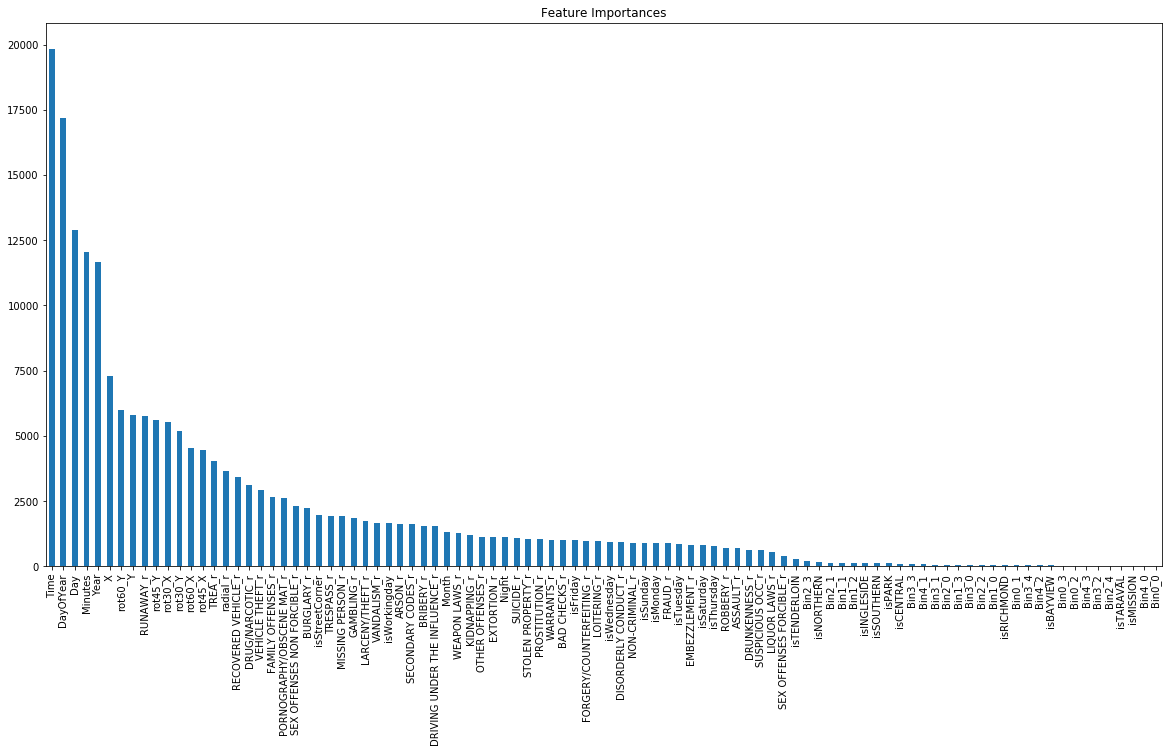

In [352]:
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(20,10))

feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()



In [354]:
features = list(feat_imp.index)
features

['Time',
 'DayOfYear',
 'Day',
 'Minutes',
 'Year',
 'X',
 'rot60_Y',
 'Y',
 'RUNAWAY_r',
 'rot45_Y',
 'rot30_X',
 'rot30_Y',
 'rot60_X',
 'rot45_X',
 'TREA_r',
 'radial_r',
 'RECOVERED VEHICLE_r',
 'DRUG/NARCOTIC_r',
 'VEHICLE THEFT_r',
 'FAMILY OFFENSES_r',
 'PORNOGRAPHY/OBSCENE MAT_r',
 'SEX OFFENSES NON FORCIBLE_r',
 'BURGLARY_r',
 'isStreetCorner',
 'TRESPASS_r',
 'MISSING PERSON_r',
 'GAMBLING_r',
 'LARCENY/THEFT_r',
 'VANDALISM_r',
 'isWorkingday',
 'ARSON_r',
 'SECONDARY CODES_r',
 'BRIBERY_r',
 'DRIVING UNDER THE INFLUENCE_r',
 'Month',
 'WEAPON LAWS_r',
 'KIDNAPPING_r',
 'OTHER OFFENSES_r',
 'EXTORTION_r',
 'Night',
 'SUICIDE_r',
 'STOLEN PROPERTY_r',
 'PROSTITUTION_r',
 'WARRANTS_r',
 'BAD CHECKS_r',
 'isFriday',
 'FORGERY/COUNTERFEITING_r',
 'LOITERING_r',
 'isWednesday',
 'DISORDERLY CONDUCT_r',
 'NON-CRIMINAL_r',
 'isSunday',
 'isMonday',
 'FRAUD_r',
 'isTuesday',
 'EMBEZZLEMENT_r',
 'isSaturday',
 'isThursday',
 'ROBBERY_r',
 'ASSAULT_r',
 'DRUNKENNESS_r',
 'SUSPICIOUS O